In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


### EDA
- Load the data.
- Look at the price variable. Does it have a long tail?

In [2]:
df = pd.read_csv("AB_NYC_2019.csv")

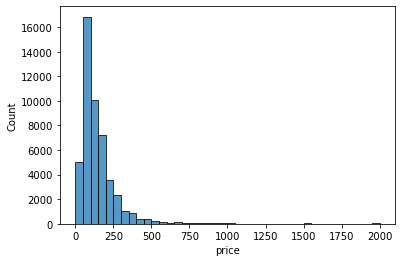

In [16]:
price = df.price[df['price'] <=2000]
sns.histplot(price , bins=40);


### Features
For the rest of the homework, you'll need to use only these columns:

- ['latitude','longitude','price','minimum_nights',
'number_of_reviews','reviews_per_month' 'calculated_host_listings_count','availability_365']
- Select only them.

In [18]:
df = df[['latitude','longitude','price','minimum_nights',
'number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']]

### Question 1
Find a feature with missing values. How many missing values does it have?

In [25]:
q1 = df.isna().sum()
q1

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

### Question 2
What's the median (50% percentile) for variable 'minimum_nights'?

In [26]:
q2 = df.minimum_nights.median()
q2

3.0

### Split the data
- Shuffle the initial dataset, use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
Make sure that the target value ('price') is not in your dataframe.
- Apply the log transformation to the price variable using the np.log1p() function.

In [33]:
def SplitData(dataset):
    n = len(dataset)
    # Split data in train/val/test sets, with 60%/20%/20% distribution
    n_val = int(n*0.2)
    n_test = int(n*0.2)
    n_trian = n - (n_val + n_test)
    #make samples random 
    idx = np.arange(n)
    np.random.seed(42)
    np.random.shuffle(idx)

    df_train = dataset.iloc[idx[:n_trian]]
    df_val = dataset.iloc[idx[n_trian:n_trian+n_val]]
    df_test = dataset.iloc[idx[n_trian+n_val:]]
    # reset indexs for train/val/test sets
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    # Apply the log transformation to the price variable using the np.log1p() function
    y_train=np.log1p(df_train.price.values) 
    y_val=np.log1p(df_val.price.values)
    y_test=np.log1p(df_test.price.values)
    #Make sure that the target value ('price') is not in your dataframe.
    del df_train["price"]
    del df_val["price"]
    del df_test["price"]

    return df_train, df_val, df_test, y_train, y_val, y_test




In [34]:
df_train, df_val, df_test, y_train, y_val, y_test = SplitData(df)


### Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

In [57]:
def train_linear_regression (X,y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])
    XTX = X.T.dot(X)
    XTX_inv=np.linalg.inv(XTX)
    w_full= XTX_inv.dot(X.T).dot(y)

    
    return w_full[0] , w_full[1:]

In [58]:
def prepare_X(dataset ,method):
    dataset = dataset.fillna(method)
    X = dataset.values
    return X

In [59]:
def rmse (y,y_pred):
    sequre = (y - y_pred)**2
    mse = sequre.mean()
    return np.sqrt(mse)

In [60]:
#fillna with 0
X_train = prepare_X(df_train ,0)
w0 , w = train_linear_regression(X_train,y_train)
X_val = prepare_X(df_val,0)
y_pred = w0 + X_val.dot(w)
rmse(y_val,y_pred).round(2)

0.64

In [61]:
#fillna with mean
X_train = prepare_X(df_train ,df_train.reviews_per_month.mean())
w0 , w = train_linear_regression(X_train,y_train)
X_val = prepare_X(df_val,df_train.reviews_per_month.mean())
y_pred = w0 + X_val.dot(w)
rmse(y_val,y_pred).round(2)

0.64

### Question 4
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?
If there are multiple options, select the smallest r.

In [62]:
# Applying the regularization parameter in our linear regression function
def train_linear_regression_reg(X, y, r=0):
    ones = np.ones(X.shape[0]) 
    X = np.column_stack([ones, X]) 

    XTX = X.T.dot(X) 
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX) 
    w_full = XTX_inv.dot(X.T).dot(y) 
    
    return w_full[0], w_full[1:] 

In [67]:
X_train = prepare_X(df_train ,0)
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    X_val = prepare_X(df_val,0)
    y_pred = w0 + X_val.dot(w)
    print('r :', r ,'RMS:' ,rmse(y_val, y_pred).round(2))

r : 0 RMS: 0.64
r : 1e-06 RMS: 0.64
r : 0.0001 RMS: 0.64
r : 0.001 RMS: 0.64
r : 0.01 RMS: 0.66
r : 0.1 RMS: 0.68
r : 1 RMS: 0.68
r : 5 RMS: 0.68
r : 10 RMS: 0.68


### Question 5
- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
-Round the result to 3 decimal digits (round(std, 3))

In [69]:
def SplitData(dataset ,seed):
    n = len(dataset)
    # Split data in train/val/test sets, with 60%/20%/20% distribution
    n_val = int(n*0.2)
    n_test = int(n*0.2)
    n_trian = n - (n_val + n_test)
    #make samples random 
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = dataset.iloc[idx[:n_trian]]
    df_val = dataset.iloc[idx[n_trian:n_trian+n_val]]
    df_test = dataset.iloc[idx[n_trian+n_val:]]
    # reset indexs for train/val/test sets
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    # Apply the log transformation to the price variable using the np.log1p() function
    y_train=np.log1p(df_train.price.values) 
    y_val=np.log1p(df_val.price.values)
    y_test=np.log1p(df_test.price.values)
    #Make sure that the target value ('price') is not in your dataframe.
    del df_train["price"]
    del df_val["price"]
    del df_test["price"]

    return df_train, df_val, df_test, y_train, y_val, y_test

In [73]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []
for seed in seed_values:
    df_train, df_val, df_test, y_train, y_val, y_test = SplitData(df,seed)
    X_train = prepare_X(df_train ,0)
    w0 , w = train_linear_regression(X_train,y_train)
    X_val = prepare_X(df_val,0)
    y_pred = w0 + X_val.dot(w)
    scores.append(rmse(y_val,y_pred))
np.std(scores).round(3)


0.008

### Question 6
- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

In [74]:
df_train, df_val, df_test, y_train, y_val, y_test = SplitData(df, 9)

df_full_train = pd.concat([df_train, df_val])
y_full_train = np.concatenate((y_train, y_val), axis=0)

X_train = prepare_X(df_full_train, 0)
w0, w = train_linear_regression_reg(X_train, y_full_train, r=0.001)
    
X_test = prepare_X(df_test, 0)
y_pred = w0 + X_test.dot(w)
rmse(y_test, y_pred)

0.6452771348658615